## Imports & Setup

In [1]:
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor, Compose, Resize, RandomHorizontalFlip, Grayscale, Normalize
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_score, recall_score
from helpers import *
from architecture.CNN import *
from architecture.AutoEncoder import *

In [2]:
torch.manual_seed(168)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Prepare Dataset

In [4]:
size = 64
batch_size = 64
transformation = Compose([RandomHorizontalFlip(), Resize((size, size)), ToTensor()])

In [5]:
root = 'real_and_fake_face/train'
train_data = create_dataset(root, transformation)
train_loader = produce_loader(train_data, batch_size)

In [6]:
root = 'real_and_fake_face/test'
test_data = create_dataset(root, transformation)
test_loader = produce_loader(test_data, batch_size)

In [7]:
root = 'real_and_fake_face/val'
val_data = create_dataset(root, transformation)
val_loader = produce_loader(val_data, batch_size)

[1026, 95, 1355, 43, 826, 133, 981, 1093, 489]


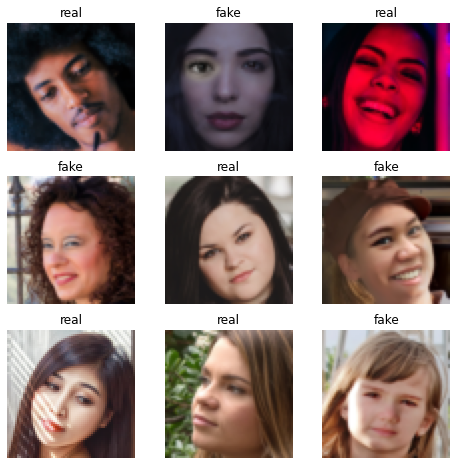

In [8]:
visualize_data(train_data)

[152, 90, 198, 124, 9, 109, 74, 124, 25]


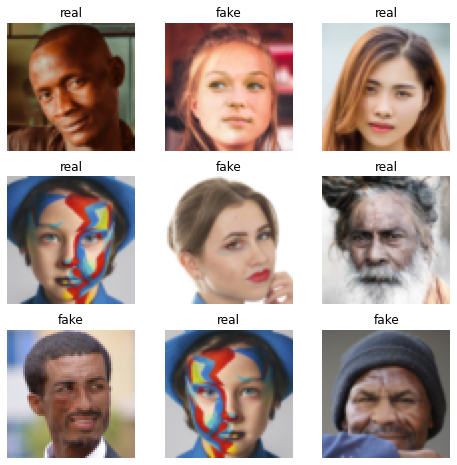

In [9]:
visualize_data(test_data)

## Load AutoEncoder

In [10]:
# number of hidden layers and their sizes
hidden_a = [3, 32, 64, 128, 256]

# kernel size of convolution layers
kernel_size_a = 3

In [11]:
autoencmodel = AutoEncoder(hidden_a, kernel_size_a).to(device)
autoencmodel.load_state_dict(torch.load("./face_autoencoder256")["model_state_dict"])

<All keys matched successfully>

In [12]:
# freeze autoencoder parameters
for param in autoencmodel.parameters():
    param.requiresGrad = False
print(autoencmodel)

AutoEncoder(
  (enc_combined): Sequential(
    (0): Encoder(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
      (batchnorm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): LeakyReLU(negative_slope=0.01)
    )
    (1): Encoder(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
      (batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): LeakyReLU(negative_slope=0.01)
    )
    (2): Encoder(
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
      (batchnorm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): LeakyReLU(negative_slope=0.01)
    )
    (3): Encoder(
      (conv): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
      (batchnorm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): LeakyReLU(negative_slope=0.01)
    )
  )
  (dec_combined): Seq

## Initialise Model

In [13]:
def create_adam_optimizer(model, lr = 0.1, betas=(0.9, 0.999), amsgrad=False):
    return optim.Adam(model.parameters(), lr = lr, amsgrad=amsgrad, betas=betas)

In [14]:
from math import floor
#sharp sobel kernels
kernels = [torch.tensor([[0., -1., 0.],
                        [-1., 5., -1.],
                        [0., -1., 0.]]),
           torch.tensor([[1., 2., 1.],
                        [0., 0., 0.],
                        [-1., -2., -1.]]),
           torch.tensor([[1., 0., -1.],
                        [2., 0., -2.],
                        [1., 0., -1.]])]

# number of hidden layers and their sizes
hidden = [256, 256, 128, 64]

# kernel size of convolution layers
kernel_size = 3

# window size of maxpooling layer
window = 2

# calculate final size of image
new_size = size-(kernel_size_a-1)*(len(hidden_a)-1)
channels = hidden[-1]
changed_img = floor( (new_size-(kernel_size-1)*(len(hidden)-1)) / window )

# calculate dimension of flattened image
flattened = channels*changed_img*changed_img

# final linear layers and their sizes
hidden_linear = [flattened, 512, 64]

In [15]:
model = DeepSearch(kernels=kernels, hidden=hidden, kernel_size=kernel_size,
                  window=window, hidden_linear=hidden_linear).to(device)
print(model)

DeepSearch(
  (conv_combined): Sequential(
    (0): DeepSearchConv(
      (conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
      (batch_norm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout2d(p=0.5, inplace=False)
    )
    (1): DeepSearchConv(
      (conv): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1))
      (batch_norm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout2d(p=0.5, inplace=False)
    )
    (2): DeepSearchConv(
      (conv): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1))
      (batch_norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout2d(p=0.5, inplace=False)
    )
  )
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear_combined): Sequential(
    (0): DeepSearchLinear(
      (linear): Linear(in_features=40000, out_features=512, bias=T

## Training Model

In [17]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

In [16]:
optimizer = create_adam_optimizer(model, lr=0.001)

In [28]:
# repeat this cell with epochs = 1 for safety, but usually epochs = 3 is a good start

"""
train function params:
device
model - model to train
train_loader - training data loader
val_loader - validation data loader
optimizer - optimizer to use (allows for saving and reloading optimizer state to stop and resume training)
epochs
criterion - loss function to use (default is cross entropy)
autoencoder - autoencoder to use, if any (default is None)

returns lists of the training loss, training accuracy, validation loss and validation accuracy for plotting curves

"""
tl, ta, vl, va = train(device, model,
                       train_loader, val_loader, 
                       optimizer, epochs = 3, autoencoder=autoencmodel)
train_losses+=tl
train_accuracies+=ta
val_losses+=vl
val_accuracies+=va

Epoch 1/3, Batch number: 0, Cumulated accuracy: 0.640625
Epoch 1/3, Batch number: 5, Cumulated accuracy: 0.625
Epoch 1/3, Batch number: 10, Cumulated accuracy: 0.6349431818181818
Epoch 1/3, Batch number: 15, Cumulated accuracy: 0.6279296875
Epoch 1/3, Batch number: 20, Cumulated accuracy: 0.6309523809523809
Epoch 1/3, Batch number: 25, Cumulated accuracy: 0.6307409675443968
--- Epoch 1/3: Train loss: 0.6395, Train accuracy: 0.6307
--- Epoch 1/3: Val loss: 0.6857, Val accuracy: 0.5539
Epoch 2/3, Batch number: 0, Cumulated accuracy: 0.671875
Epoch 2/3, Batch number: 5, Cumulated accuracy: 0.6640625
Epoch 2/3, Batch number: 10, Cumulated accuracy: 0.6576704545454546
Epoch 2/3, Batch number: 15, Cumulated accuracy: 0.6572265625
Epoch 2/3, Batch number: 20, Cumulated accuracy: 0.6510416666666666
Epoch 2/3, Batch number: 25, Cumulated accuracy: 0.6466625842008573
--- Epoch 2/3: Train loss: 0.6342, Train accuracy: 0.6467
--- Epoch 2/3: Val loss: 0.7328, Val accuracy: 0.5392
Epoch 3/3, Batch n

## Testing Model & Performance Curves

In [29]:
"""
test function params:
device
model - model to train
data_loader - chosen (testing) data loader
criterion - loss function to use (default is cross entropy)
autoencoder - autoencoder to use, if any (default is None)
get_predictions - if True, returns the list of true labels, the list of predictions made by the model, 
                  and values of the test loss and test accuracy (default is False)

by default, returns values of the test loss and test accuracy

"""
true_labels, model_preds, test_loss, test_accuracy = test(device, model, test_loader, autoencoder=autoencmodel, get_predictions=True)

Test loss: 0.7303, Test accuracy: 0.5196


Precision: 0.5409836065573771
Recall: 0.6111111111111112
F1 score: 0.5739130434782609


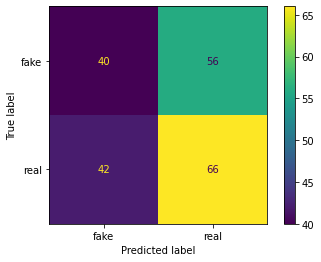

In [30]:
show_metrics(true_labels, model_preds)

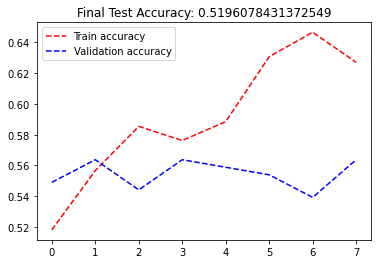

In [31]:
plt.plot(train_accuracies, "r--", label='Train accuracy')
plt.plot(val_accuracies, "b--", label='Validation accuracy')
plt.title("Final Test Accuracy: {}".format(test_accuracy))
plt.legend(loc='upper left')
plt.show()

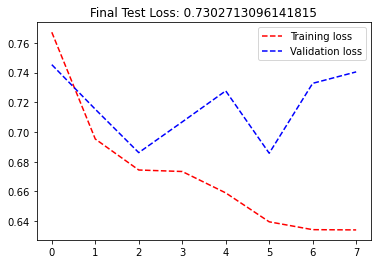

In [32]:
plt.plot(train_losses, "r--", label='Training loss')
plt.plot(val_losses, "b--", label='Validation loss')
plt.title("Final Test Loss: {}".format(test_loss))
plt.legend(loc='upper right')
plt.show()

## Viewing Model Predictions

In [33]:
test_loader2 = produce_loader(test_data, 1)

In [34]:
correct_list, wrong_list, true_labels2, model_preds2 = get_pictures_test(device, model, test_loader2, autoencoder=autoencmodel)

Precision: 0.5474452554744526
Recall: 0.6944444444444444
F1 score: 0.6122448979591837


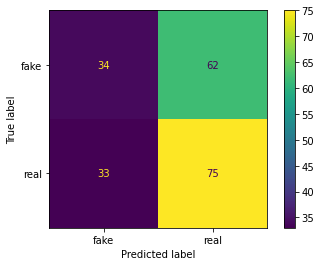

In [35]:
show_metrics(true_labels2, model_preds2)

[57, 8, 44, 88, 7, 67, 18, 67, 79, 51, 15, 29, 24, 83, 83, 12, 12, 25, 64, 32, 20, 47, 61, 65, 3]


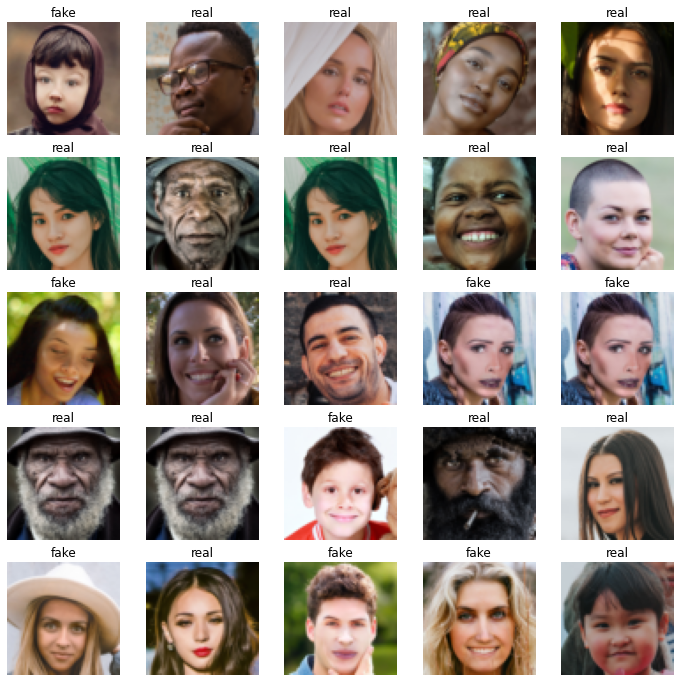

In [36]:
visualize_data(correct_list, (12,12), 5)

[45, 15, 93, 60, 52, 63, 88, 85, 66, 24, 53, 49, 40, 38, 47, 19, 41, 2, 17, 44, 42, 20, 13, 74, 91]


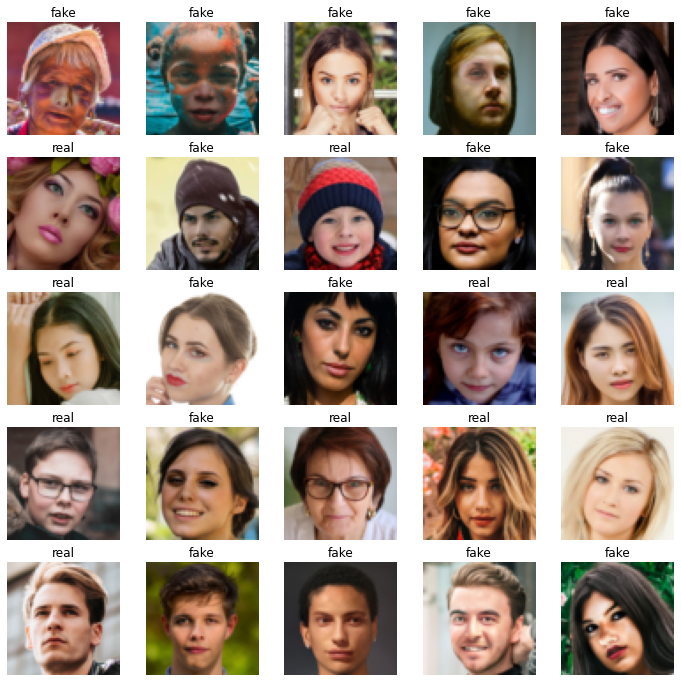

In [37]:
visualize_data(wrong_list, (12,12), 5)

## Saving Model

In [ ]:
torch.save({'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()}, 
            './CNNwAE')

model_test = DeepLearn(kernels=kernels, hidden=hidden, kernel_size=kernel_size, window=window,
                   hidden_linear=hidden_linear, labels=labels).to(device)
model_test.load_state_dict(torch.load("./latest_16epochs")["model_state_dict"])